# **01-03-2024** 
**`audio_sheet_retrieval/audio2sheet_align.py`**

In [1]:
from __future__ import print_function

import sys
import yaml
from tqdm import tqdm

from msmd.data_model.piece import Piece
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
split_file = '/Users/margarita/Documents/DKE Master/Master Thesis - Music Score Localisation/msmd/msmd/splits/all_split.yaml'
config_file = '/Users/margarita/Documents/DKE Master/Master Thesis - Music Score Localisation/audio_sheet_retrieval/audio_sheet_retrieval/exp_configs/mutopia_no_aug.yaml'
DATA_ROOT_MSMD = '/Users/margarita/Documents/DKE Master/Master Thesis - Music Score Localisation/msmd_aug_v1-1_no-audio'

with open(config_file, 'rb') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
def load_split(split_file):
    with open(split_file, 'rb') as f:
        split = yaml.load(f, Loader=yaml.FullLoader)
    return split

In [4]:
SHEET_CONTEXT = 200
SYSTEM_HEIGHT = 160
SPEC_CONTEXT = 42
SPEC_BINS = 92


NO_AUGMENT = dict()
NO_AUGMENT['system_translation'] = 0
NO_AUGMENT['sheet_scaling'] = [1.00, 1.00]
NO_AUGMENT['onset_translation'] = 0
NO_AUGMENT['spec_padding'] = 0
NO_AUGMENT['interpolate'] = -1
NO_AUGMENT['synths'] = ['ElectricPiano']
NO_AUGMENT['tempo_range'] = [1.00, 1.00]

# this will be overwritten with a config file
# (see audio_sheet_retrieval/exp_configs)
AUGMENT = dict()
for key in NO_AUGMENT.keys():
    AUGMENT[key] = NO_AUGMENT[key]
    
if not config_file:
    spec_context = SPEC_CONTEXT
    sheet_context = SHEET_CONTEXT
    staff_height = SYSTEM_HEIGHT
    augment = AUGMENT
    no_augment = NO_AUGMENT
    test_augment = NO_AUGMENT.copy()
else:
    with open(config_file, 'rb') as hdl:
        config = yaml.load(hdl, Loader=yaml.FullLoader)
    spec_context = config["SPEC_CONTEXT"]
    sheet_context = config["SHEET_CONTEXT"]
    staff_height = config["SYSTEM_HEIGHT"]
    augment = config["AUGMENT"]
    no_augment = NO_AUGMENT
    test_augment = NO_AUGMENT.copy()
    test_augment['synths'] = [config["TEST_SYNTH"]]
    test_augment['tempo_range'] = [config["TEST_TEMPO"], config["TEST_TEMPO"]]



In [46]:
from audio_sheet_retrieval.utils.data_pools import prepare_piece_data, AudioScoreRetrievalPool
piece_names = ['BachJS__BWV790__bwv790', 'BachJS__BWV952__fugue-c-major', 'Mendelssohn-BartholdyF__O19__5.Inquietude', 'SchumannR__O124__16-berceuse']
all_images = []
all_specs = []
all_o2c_maps = []
for ip in tqdm(range(len(piece_names)), ncols=70):
    piece_name = piece_names[ip]

    try:
        image, specs, o2c_maps = prepare_piece_data(DATA_ROOT_MSMD, piece_name,
                                                    aug_config=augment, require_audio=False)
    except:
        print("Problems with loading piece %s" % piece_name)
        print(sys.exc_info()[0])
        continue

    # keep stuff
    all_images.append(image)
    all_specs.append(specs)

100%|███████████████████████████████████| 4/4 [00:08<00:00,  2.16s/it]


In [48]:
example_piece = piece_names[3]
piece_image, piece_specs, piece_o2c_maps = prepare_piece_data(DATA_ROOT_MSMD, piece_name,
                                                    aug_config=augment, require_audio=False)

In [93]:
# initialize data pool with piece
piece_pool = AudioScoreRetrievalPool([piece_image], [piece_specs], [piece_o2c_maps], data_augmentation=test_augment, shuffle=False)
spectrogram = piece_pool.specs[0][0]
sheet = piece_pool.images[0]

(200, 24921)


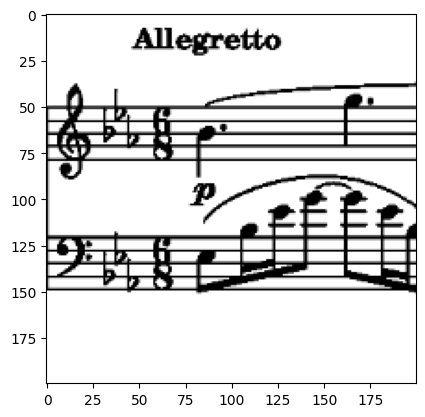

In [135]:
print(piece_pool.images[0].shape)
plt.imshow(piece_pool.images[0][:, :200], cmap='gray')
plt.show()

(92, 4767)


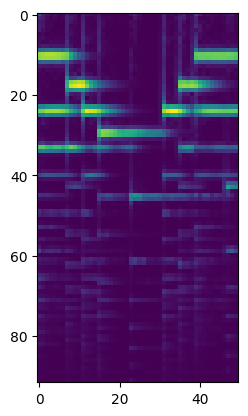

In [95]:
# plt.imshow((piece_pool.specs[0][0][:, :piece_pool.specs[0][0].shape[0]]))
print(piece_pool.specs[0][0].shape)
plt.imshow((piece_pool.specs[0][0][:, :50]))
plt.show()

In [96]:
coordinates = piece_pool.o2c_maps[0][0][:, 1]
onsets = piece_pool.o2c_maps[0][0][:, 0]
len(piece_pool.o2c_maps), len(piece_pool.o2c_maps[0]), (piece_pool.o2c_maps[0][0].shape), coordinates.shape, onsets.shape

(1, 1, (781, 2), (781,), (781,))

In [97]:
coordinates[:5], onsets[:5]

(array([ 87, 110, 127, 145, 166]), array([ 0,  8, 12, 16, 24]))

In [114]:
print(f'sheet image shape: {sheet.shape} | spectrogram shape:{spectrogram.shape}')
SPEC_CONTEXT = 42
INPUT_SHAPE_1 = [1, 160, 200]
INPUT_SHAPE_2 = [1, 92, SPEC_CONTEXT]

sheet_window_shape = INPUT_SHAPE_1[1:]
spectrogram_window_shape = INPUT_SHAPE_2[1:]


# prepare sample points
SHEET_STEP = 10
sheet_steps = sheet.shape[1] // SHEET_STEP
coordinate_0 = sheet_window_shape[1] //2
coordinate_1 = sheet.shape[1] - sheet_window_shape[1] //2
sheet_idxs = np.linspace(coordinate_0, coordinate_1, sheet_steps, dtype=int)


SPECTROGRAM_STEP = 2 
spectrogram_steps = spectrogram.shape[1] // SPECTROGRAM_STEP
onset_0 = spectrogram_window_shape[1] //2
onset_1 = spectrogram.shape[1] - spectrogram_window_shape[1] //2
spectrogram_idxs = np.linspace(onset_0, onset_1, spectrogram_steps, dtype=int)

sheet image shape: (200, 24921) | spectrogram shape:(92, 4767)


In [113]:
INPUT_SHAPE_1[1:], INPUT_SHAPE_2[1:],  sheet_window_shape[1],  sheet.shape[1]

([160, 200], [92, 42], 200, 24921)

In [115]:
sheet_idxs[:5], spectrogram_idxs[:5]

(array([100, 109, 119, 129, 139]), array([21, 22, 24, 26, 28]))

## Slice sheet images and spectrogram imagaes

In [116]:
sheet_slices = np.zeros((len(sheet_idxs), 1, sheet_window_shape[0], sheet_window_shape[1]), dtype=np.float32)
region_0 = sheet.shape[0]//2 - sheet_window_shape[0]//2
region_1 = region_0 + sheet_window_shape[0]
for j, x_coordinate in enumerate(sheet_idxs):
    sheet_slice = sheet[region_0:region_1, x_coordinate - coordinate_0 : x_coordinate + coordinate_0]   
    sheet_slices[j, 0] = sheet_slice

In [117]:
len(sheet_slices), sheet_slices[0].shape

(2492, (1, 160, 200))

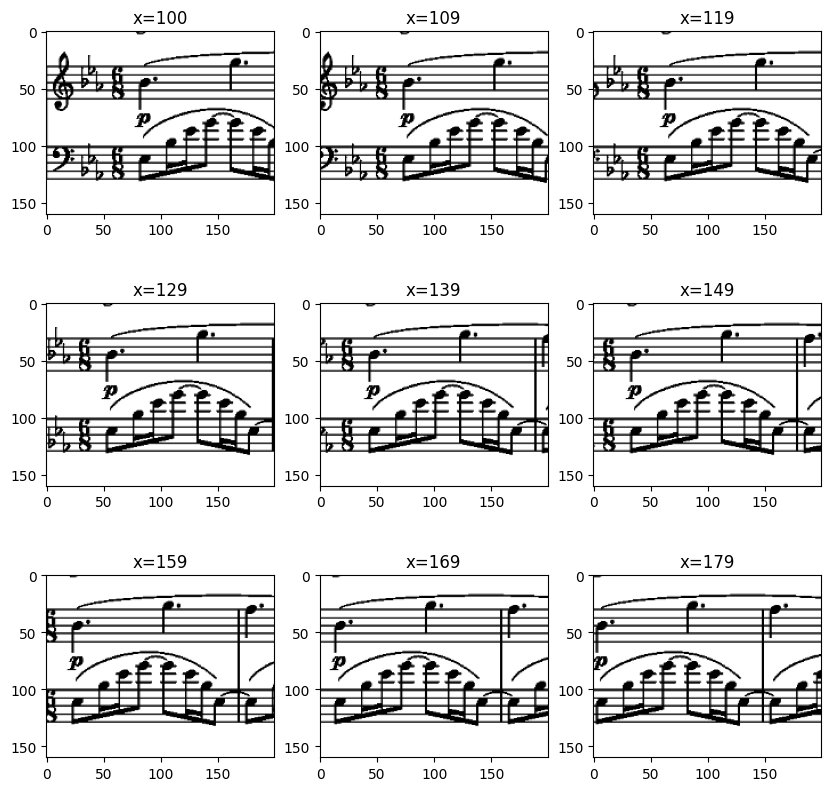

In [129]:
plt.figure('Sheet slices', figsize=(10, 10))

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(sheet_slices[i, 0], cmap='gray')
    plt.title(f'x={sheet_idxs[i]}')

plt.show()

In [130]:
# Slide audio
spectrogram_slices = np.zeros((len(spectrogram_idxs), 1,  spectrogram_window_shape[0], spectrogram_window_shape[1]), dtype=np.float32)
for j, onset in enumerate(spectrogram_idxs):
    spectrogram_slice = spectrogram[:, onset - onset_0 : onset + onset_0]
    spectrogram_slices[j, 0] = spectrogram_slice

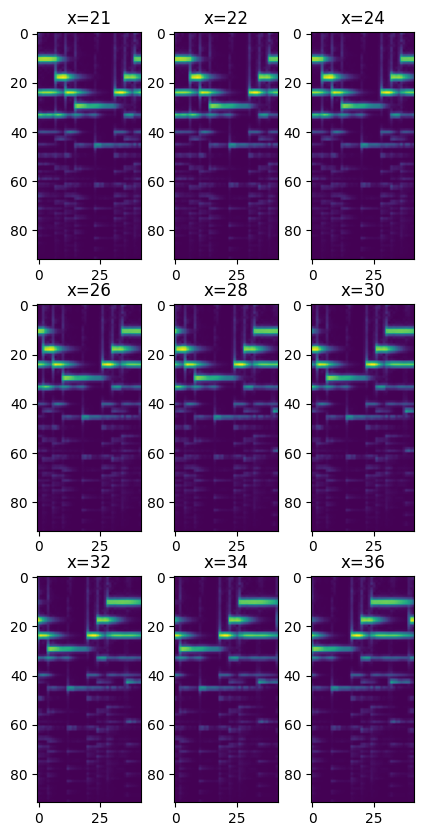

In [131]:
plt.figure('Spectrogram slices', figsize=(5, 10))

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(spectrogram_slices[i, 0], cmap='viridis')
    plt.title(f'x={spectrogram_idxs[i]}')

plt.show()

142.0

In [136]:
DIM_LATENT = 32

In [137]:
# Shapes of final img_codes and specs_codes:

img_codes = np.zeros((sheet_slices.shape[0], DIM_LATENT), dtype=np.float32) 
specs_codes = np.zeros((spectrogram_slices.shape[0], DIM_LATENT), dtype=np.float32)
img_codes.shape, specs_codes.shape

((2492, 32), (2383, 32))